# Image Segmentation on Forest Imagery

CSC 522 Fall 2024

- Anthony Wu, awu3
- Jheel Gala, jgala	
- Ophelia Sin, oysin
- Venkata Sai Praveen Gunda, vgunda



In [109]:
### import required packages

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data Preprocessing

In [118]:
base_dir = 'data_new'

original_dir = os.path.join(base_dir, 'original')
mask_dir = os.path.join(base_dir, 'mask')


In [119]:
# Load and preprocess original image

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  
    img = tf.image.resize(img, [224, 224])  
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [120]:
# Load mask

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    
    # Decode PNG image, keeping all channels (including alpha)
    mask = tf.image.decode_png(mask, channels=4)  # RGBA (4 channels)

    # Extract the alpha channel (transparency)
    alpha_channel = mask[:, :, 3]  # Alpha channel is the 4th channel

    # Create a binary mask: 1 for opaque (non-transparent), 0 for transparent
    binary_mask = tf.where(alpha_channel > 0, 1.0, 0.0)

    # Resize the binary mask to match (224x224)
    binary_mask = tf.image.resize(binary_mask[..., tf.newaxis], [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return binary_mask

In [121]:
# Function to load both image and mask together
def load_image_and_mask(image_path, mask_path):
    image = load_and_preprocess_image(image_path)
    mask = load_mask(mask_path)
    return image, mask

In [122]:
# Get list of all images and masks
original_paths = sorted([os.path.join(original_dir, fname) for fname in os.listdir(original_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

In [151]:
# Create TensorFlow Dataset from the file paths of original images and masks
dataset = tf.data.Dataset.from_tensor_slices((original_paths, mask_paths))
print(dataset.element_spec)
buffer_size = 1000
dataset = dataset.shuffle(buffer_size)
dataset = dataset.map(load_image_and_mask)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


In [152]:
# Split the dataset into training, validation, and test datasets
total_count = len(list(dataset))
train_count = int(0.7 * total_count)
validation_count = int(0.1 * total_count)
test_count = int(0.2 * total_count)


train_dataset = dataset.take(train_count)
remaining = dataset.skip(train_count)
val_dataset = remaining.take(validation_count)
test_dataset = remaining.skip(validation_count)

2024-11-19 16:38:51.918979: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:38:51.933763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:38:51.941553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:38:51.944215: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:38:51.949780: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:38:51.952520: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:38:51.952776: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:38:51.956966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:38:51.957638: W tensorflow/core/lib/png/png_io.cc:89] PNG 

In [153]:
validation_count

12

### Visualizing the Images

In [154]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask',]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

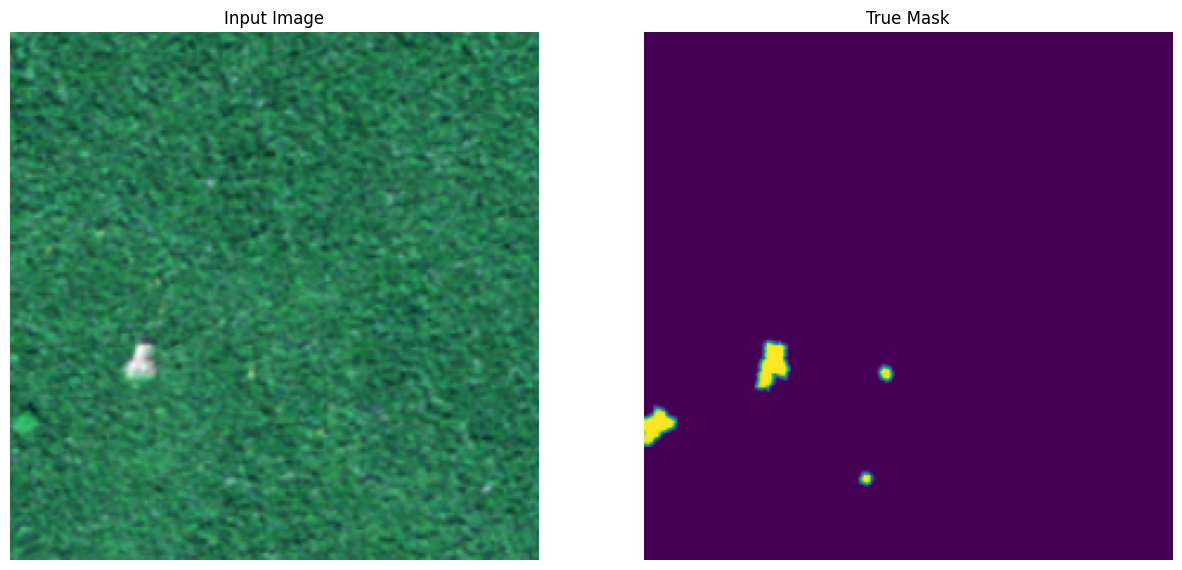

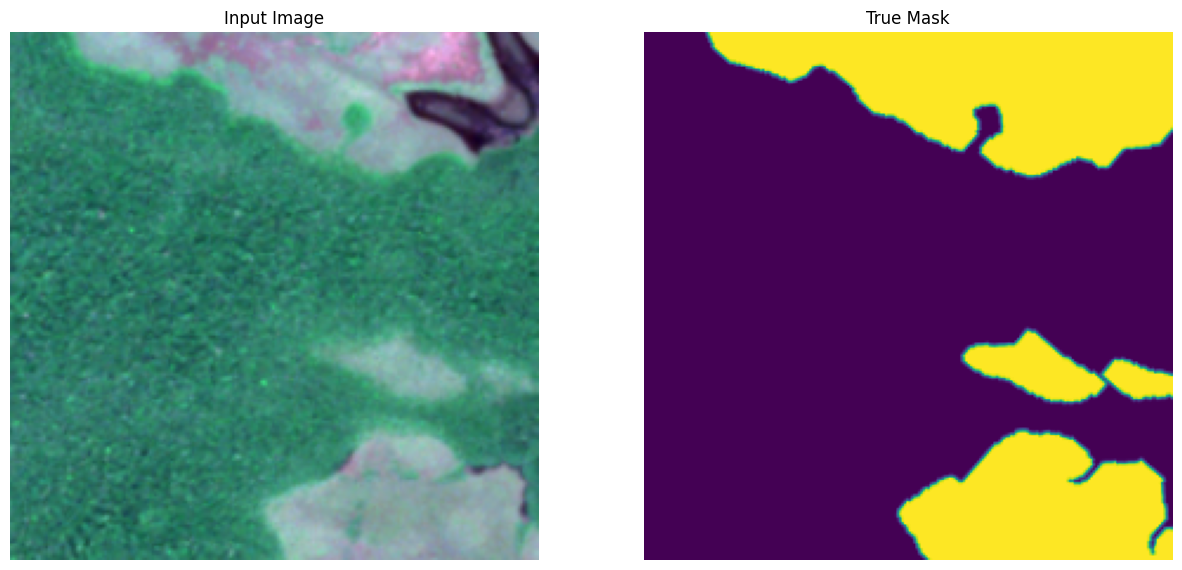

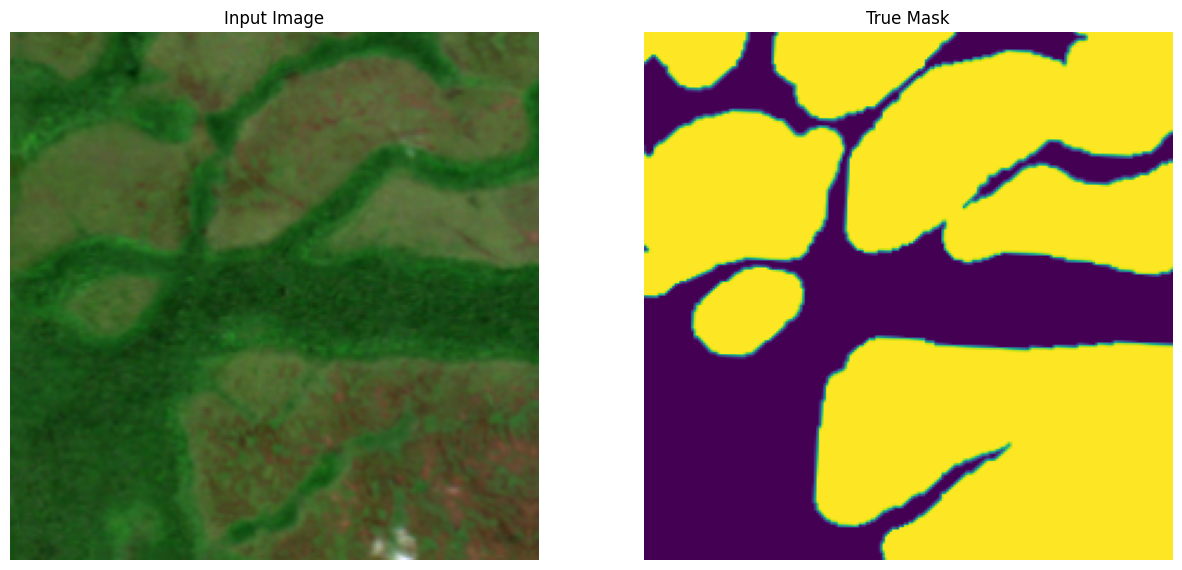

In [155]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Prepare for Modeling

In [156]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
            tf.keras.layers.RandomRotation(0.2, seed=seed),
            tf.keras.layers.RandomZoom(0.2, seed=seed)
        ])
        
    self.augment_labels = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        tf.keras.layers.RandomRotation(0.2, seed=seed),
        tf.keras.layers.RandomZoom(0.2, seed=seed)
    ])

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [157]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [158]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

# Prepare the validation dataset without data augmentation
validation_batches = (
    val_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Prepare the test dataset without data augmentation
test_batches = (
    test_dataset
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [159]:
from tensorflow_examples.models.pix2pix import pix2pix

# Pretrained network
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Specific layers in MobileNetV2
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

# Get output layers corresponding to the layer names
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Freezing Weights for Pretrained Model
down_stack.trainable = False


In [160]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [161]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
    filters=output_channels, kernel_size=3, strides=2,
    padding='same', activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 1
model=unet_model(output_channels=OUTPUT_CLASSES)

In [162]:
def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true,[1, 2, 3]) + tf.reduce_sum(y_pred,[1, 2, 3]) - intersection
    iou = intersection / union
    return iou

In [163]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', iou_metric])

Let's look at the predictions before training the model.

In [164]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [165]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in train_batches.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [166]:
# show_predictions()

## Training

In [167]:
EPOCHS = 20
VAL_SUBSPLITS = 5
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = validation_count // BATCH_SIZE

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_batches,
    validation_steps=validation_steps,
    callbacks=[callback, lr_schedule]
)

Epoch 1/20


2024-11-19 16:39:01.560579: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.569616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.572724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.575581: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.584884: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.588102: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.598109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.603812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:01.603905: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6432 - iou_metric: 0.0849 - loss: 0.6299

2024-11-19 16:39:06.872667: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.876272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.883421: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.888172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.897871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.900858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.902364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.903716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:39:06.907731: W tensorflow/core/lib/png/png_io.cc:89] PNG 

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6545 - iou_metric: 0.0825 - loss: 0.6224 - val_accuracy: 0.7971 - val_iou_metric: 0.0450 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7898 - iou_metric: 0.0306 - loss: 0.5177 - val_accuracy: 0.8401 - val_iou_metric: 0.0141 - val_loss: 0.4724 - learning_rate: 0.0010
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8363 - iou_metric: 0.0212 - loss: 0.4204 - val_accuracy: 0.8483 - val_iou_metric: 0.0070 - val_loss: 0.4342 - learning_rate: 0.0010
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8158 - iou_metric: 0.0205 - loss: 0.4094 - val_accuracy: 0.8503 - val_iou_metric: 0.0177 - val_loss: 0.4139 - learning_rate: 0.0010
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7831 - iou_metric: 0.0286 - loss: 0.4325 - val_accuracy: 0.8500 - val_iou_metric: 0.0590 - val_loss: 0.4064 - learning_rate: 0.0010
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

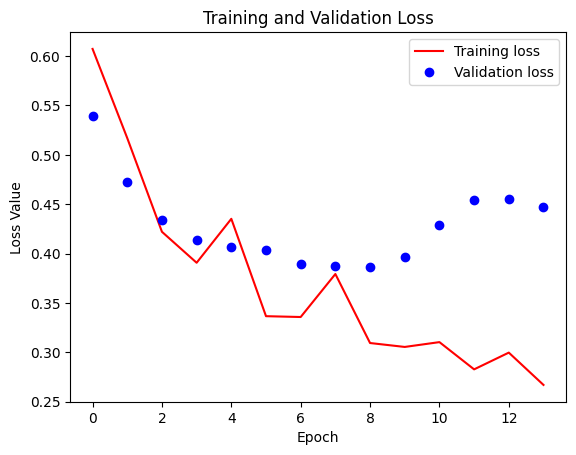

In [168]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

##  Predictions

In [169]:
predict = model.predict(test_batches)

2024-11-19 16:40:07.826829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:40:07.829406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:40:07.833664: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:40:07.842669: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:40:07.849844: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:40:07.862255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:40:07.896873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:40:07.896922: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-19 16:40:07.925599: W tensorflow/core/lib/png/png_io.cc:89] PNG 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [170]:
predicted_masks = (predict>0.5).astype(int)

In [171]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_iou = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test IOU: {test_iou}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step - accuracy: 0.8551 - iou_metric: 0.3434 - loss: 0.3984
Test Loss: 0.39839160442352295
Test IOU: 0.3433937728404999
Test Accuracy: 85.51%


In [172]:
predicted_masks.shape

(25, 224, 224, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


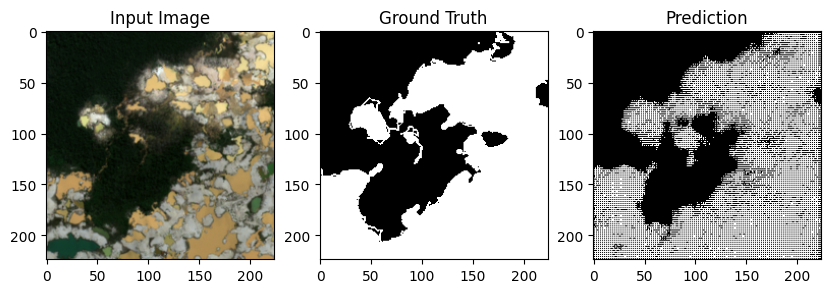

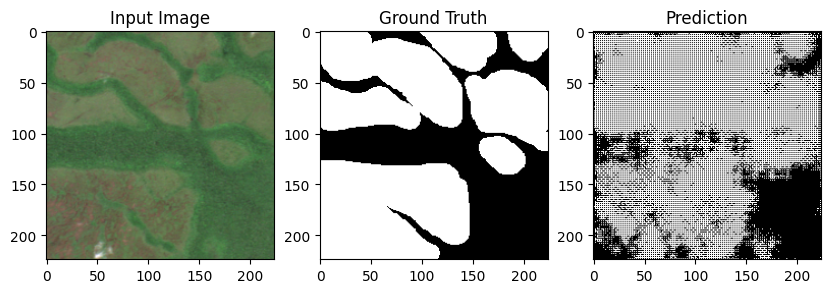

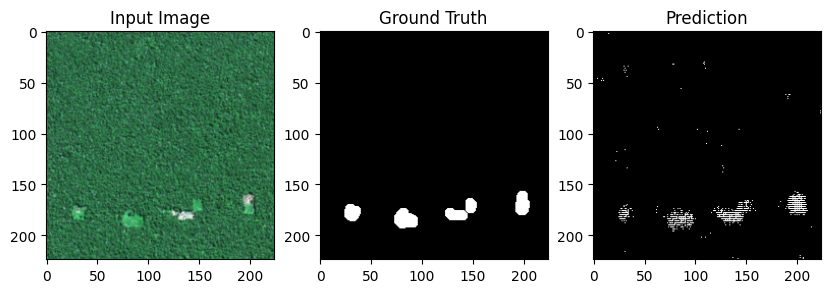

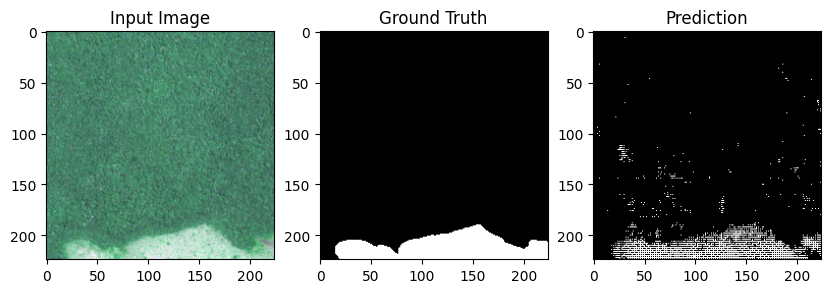

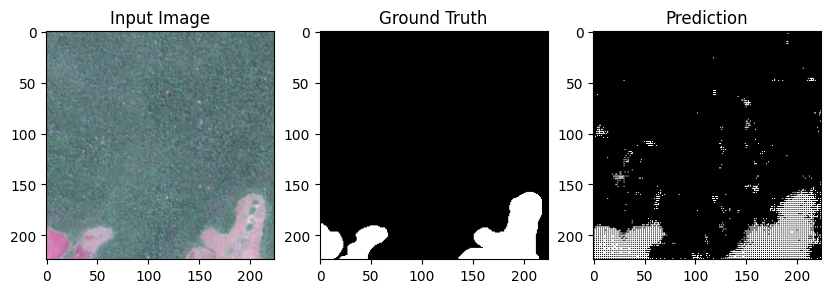

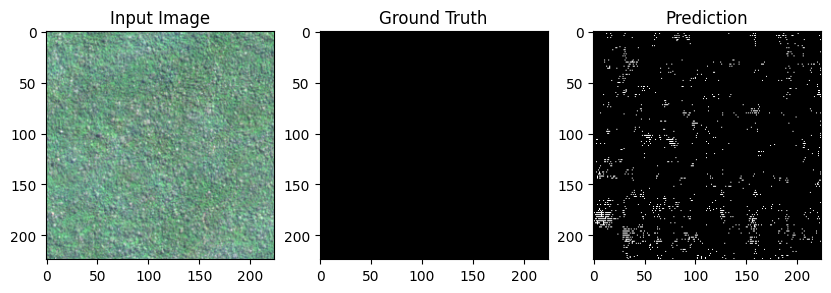

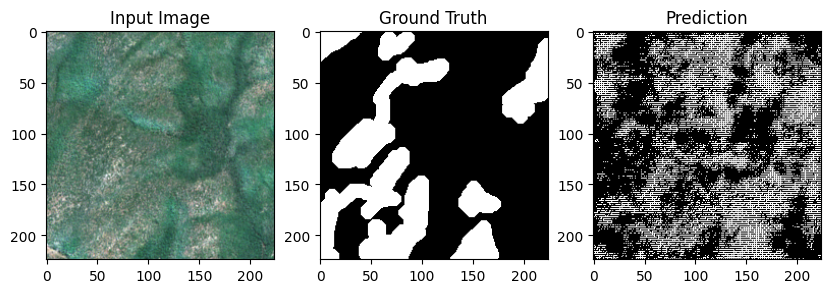

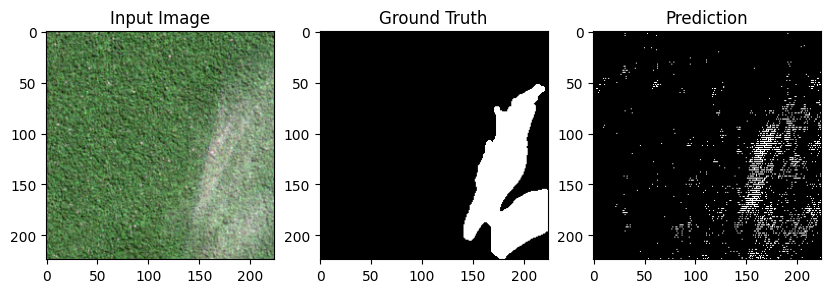

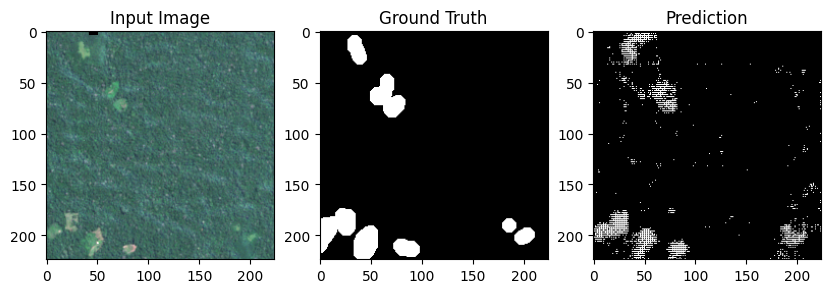

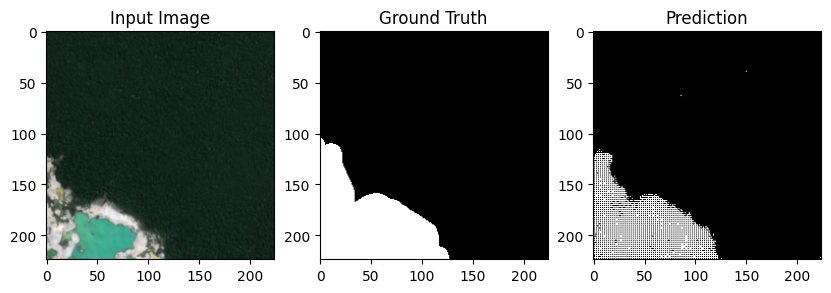

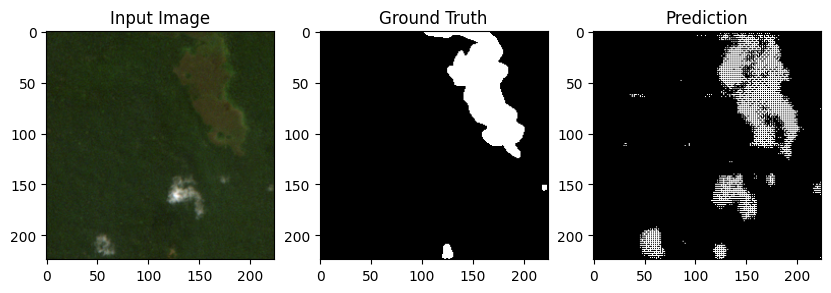

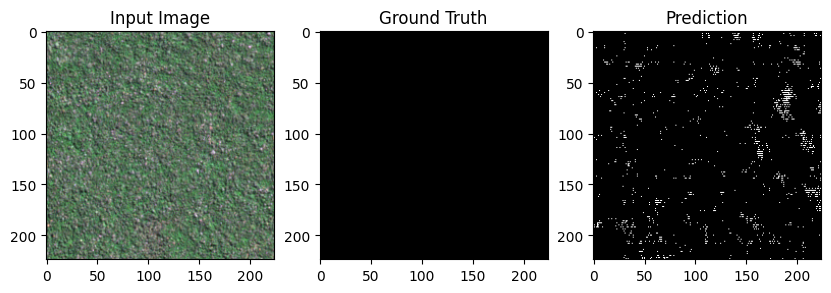

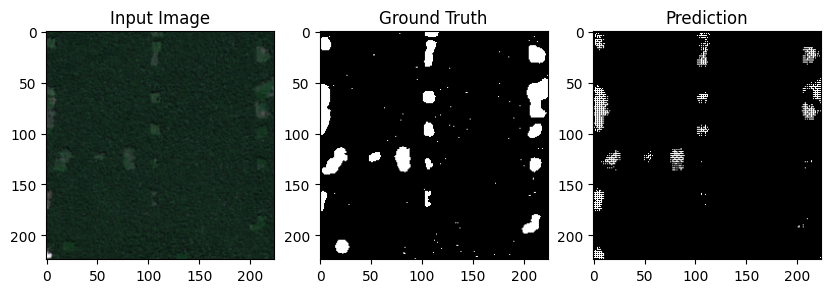

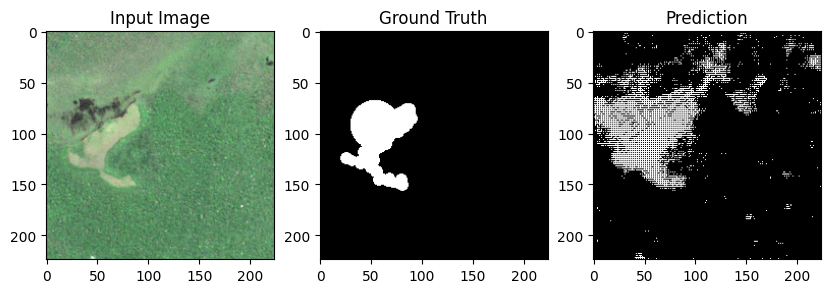

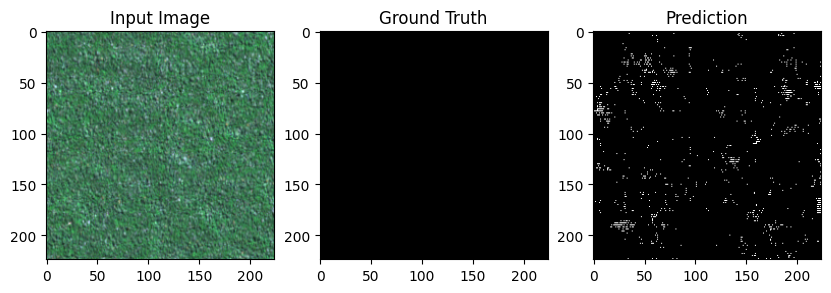

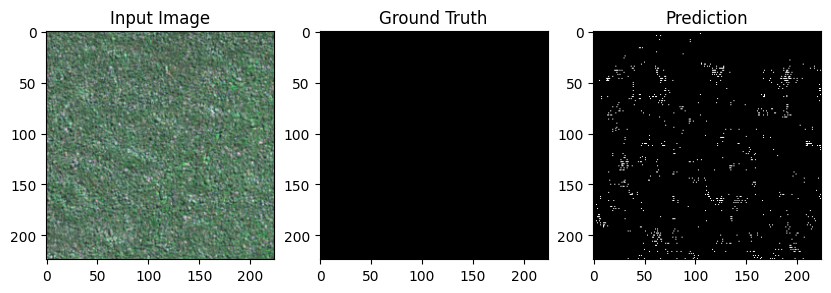

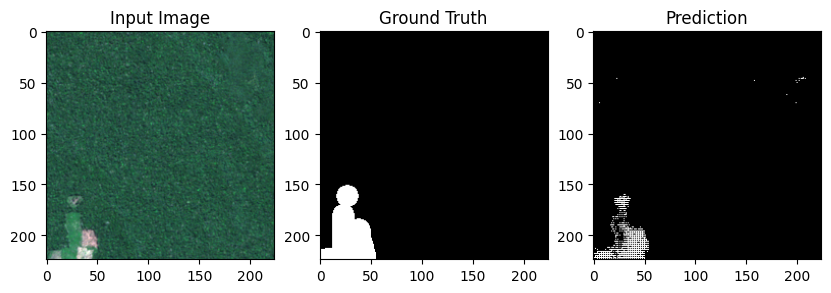

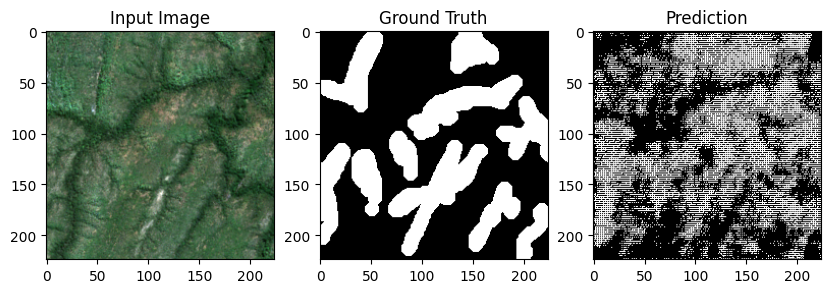

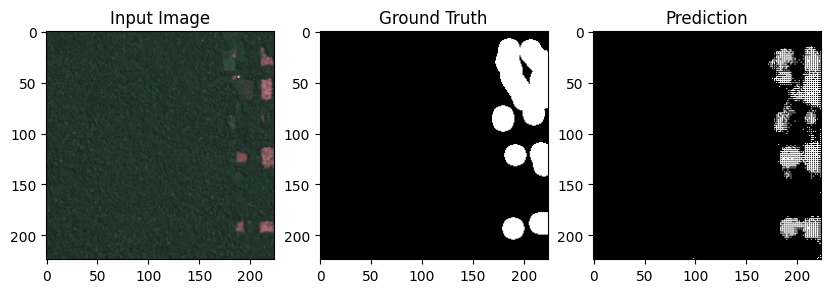

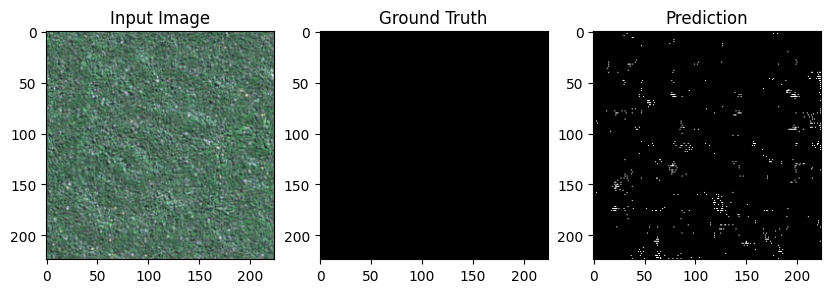

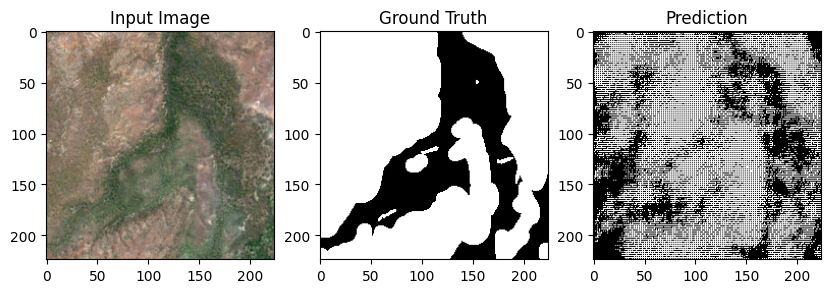

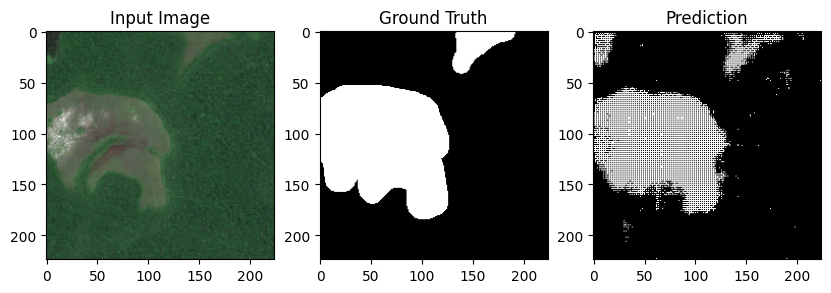

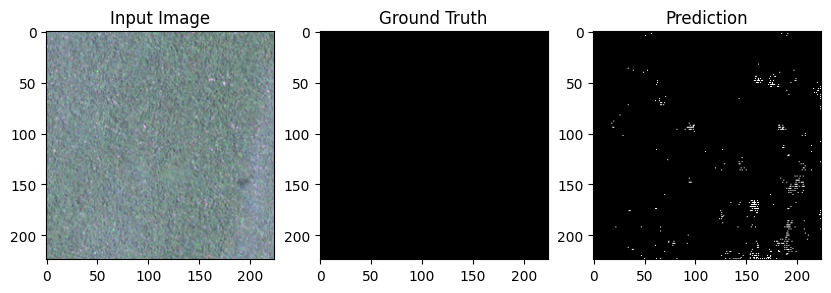

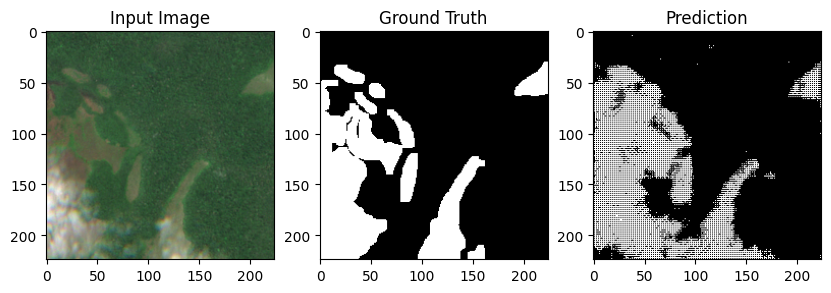

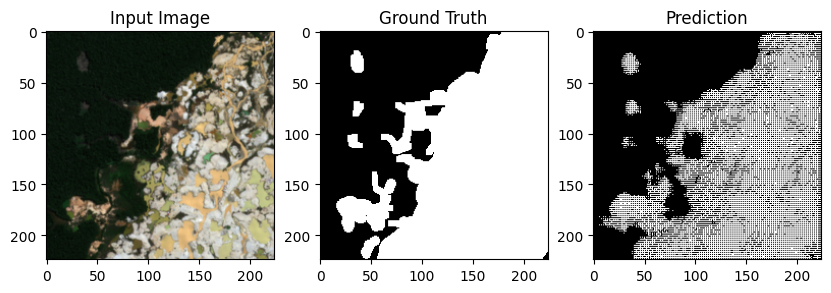

In [173]:
import matplotlib.pyplot as plt

# Function to display images, ground truth masks, and predicted masks
def display_sample(image, ground_truth, prediction):
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(prediction, cmap='gray')

    plt.show()

# Iterate through the test dataset and display results
for images, masks in test_batches.take(100):  # Display 5 samples
    preds = model.predict(images)
    predicted_masks = (preds>0.6).astype(np.uint8)
    for i in range(len(images)):
        display_sample(images[i].numpy(), masks[i].numpy().squeeze(), predicted_masks[i].squeeze())